# このPythonプログラムで何を実現するのか
- Titanic datasetのスプレッドシートをリレーショナルデータベース用のデータに整形する

# この演習で何を学べるのか
- Pythonの基礎（pandas, os, sqlite, matplotlib, seabornライブラリの使用方法、関数の定義、条件分岐、ファイルの読み書き、コメントの挿入など）
- データベース（SQLite）の基礎
- Pythonによる可視化の方法とカスタマイズ

# 下準備
- 左上のファイルから、ファイルのコピーを保存する（あるいはノートブック（「TitanicDataset_to_DB.ipynb」）をアップロードする）（注参照）
- Titanic_passenger_data.xlsxを同じディレクトリ（フォルダ）にアップロードする

- 注：大学のアカウントでは、セキュリティの問題でノートブックを開けないように設定されているようです。この実習では、個人のGoogleアカウントを使用するようにしてください。アカウントの切り替えだけでは開けないため、一度個人のGoogleアカウントでColaboratoryにアクセスし、ノートブックをアップロードします。

# Excelファイルをリレーショナルデータベース用の複数のcsvデータに整形する

## Google Driveをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


まずはマウントしてGoogle Drive上にアップロードしたファイルにアクセスできるようにする

## ファイルを読み込む

### 1. ライブラリのインポート

In [ ]:
import pandas as pd
import os

まずは必要なライブラリをimportします。

pandasは、Excelやcsv、tsvなどを操作するライブラリです。

Pythonで人文系のデータ分析・可視化をしようとすると、ほぼ必須で使います。

### 2. ファイルの読み込み

In [ ]:
# Excelファイルを読み込む
file_path = '/content/drive/MyDrive/Colab Notebooks/Titanic_passenger_data.xlsx'
df = pd.read_excel(file_path)

次に、Excelファイルを読み込みましょう。
- エラーが出る場合
  - Google DriveのColab Notebooksというフォルダ（このTitanicDataset_to_DB.ipynbが保存されているフォルダ）にTitanic_passenger_data.xlsxが保存されているかを再度確認してください
- 保存されていない場合は、左のフォルダアイコンからColab Notebooksにいき、右に表示されている縦の3点リーダからアップロードしましょう



```
df = pd.read_excel(file_path)
```
というのは、pandasライブラリを使って指定したパスのファイルを読み込んでくださいね、という命令です。

`.read_excel`
という部分は、読み込むファイルがExcelファイルであることをコンピュータに伝えています。

ここで読み込まれたデータは、「データフレーム」という形式でdfという名前の変数に入っています。


In [ ]:
# 実験用
print(df)

      PassengerID  Survived  PcClass  \
0          100001         0        3   
1          100002         1        1   
2          100003         1        3   
3          100004         1        1   
4          100005         0        3   
...           ...       ...      ...   
1304       101305         0        3   
1305       101306         1        1   
1306       101307         0        3   
1307       101308         0        3   
1308       101309         0        3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                    

pandasのデータフレームは「二次元ラベル付きデータ構造」と呼ばれるものです。Excelのスプレッドシートに似た形式で行と列から構成されています。

各行は一意のインデックスによって識別されます。


上記で表示されたデータフレームのうち、一番左に表示される0から始まる数字がインデックス番号です。

#### 補足：データベースとは

- データを組織的に格納し、管理するためのシステム
- 情報を簡単に検索、追加、更新、削除できるようにすることを目的とする
- データベース管理システム（DBMS, Database Management System）というソフトフェアを使用して管理する
  - DBMSの例：MySQL、Oracle Database、Microsoft SQL Server
- Excelのようなスプレッドシート（SS）との違い
  - データの構造化と整合性：SSはユーザが自由にデータを入力・整理できるが、DBは厳密なデータ構造（テーブル、リレーション）があり、データの整合性と一貫性を保てる
 - データの処理能力
  - SSは小規模〜中規模のデータセット向け
  - DBは大規模なデータセットや複雑なデータ操作、多数の同時アクセスに適している
- スケーラビリティ：SSはデータ量が増加するとパフォーマンスが低下しやすいが、DBはデータ量が増加してもパフォーマンスを維持しやすい

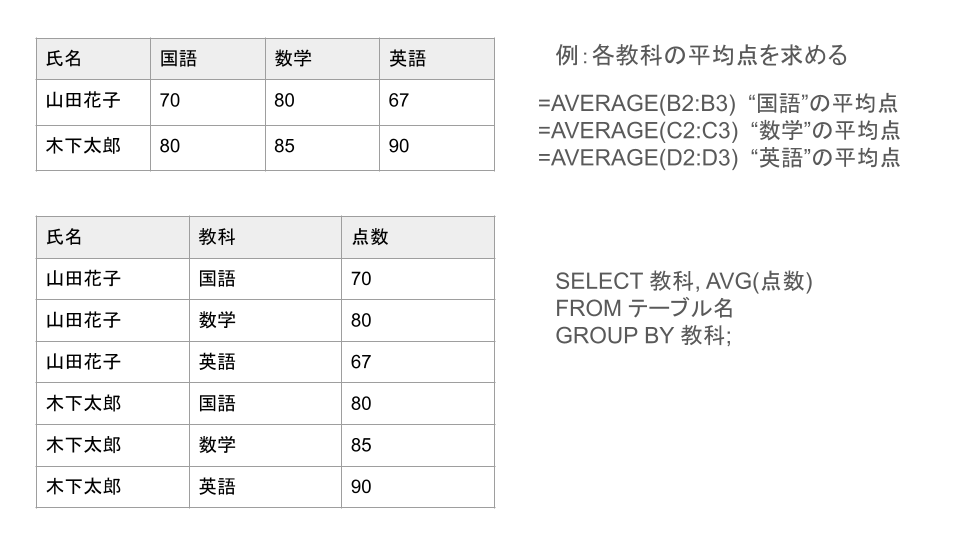

### Excelのヘッダーを参考に、シートをテーブルに分割する

この例では、以下のような分類で各テーブルを作成します。

- **Passengers Table（乗客テーブル）**:
  - PassengerID（乗客ID）: プライマリーキー
  - Name（名前）
  - Sex（性別）
  - Age（年齢）
- **Tickets Table（チケットテーブル）**:
  - TicketID（チケットID）: チケット番号、プライマリーキー
  - PassengerID（乗客ID）: 乗客テーブルとの関連付け
  - Fare（料金）
  - Cabin（客室番号）
- **Travel Class Table（旅客クラステーブル）**:
  - ClassID（クラスID）: 旅客クラス（1, 2, 3）
  - PassengerID（乗客ID）: 乗客テーブルとの関連付け
- **Family Table（家族テーブル）**:
  - FamilyID（家族ID）: プライマリーキー
  - PassengerID（乗客ID）: 乗客テーブルとの関連付け
  - SibSp（兄弟姉妹/配偶者の数）
  - Parch（親/子供の数）
- **Embarkation Table（出港地テーブル）**:
  - EmbarkationID（出港地ID）: 出港地（C, Q, S）
  - PassengerID（乗客ID）: 乗客テーブルとの関連付け
- **Survival Table（生存テーブル）**:
  - SurvivalID（生存ID）: プライマリーキー
  - PassengerID（乗客ID）: 乗客テーブルとの関連付け
  - Survived（生存状態）

In [ ]:
# 乗客テーブル
passengers = df[['PassengerID', 'Name', 'Sex', 'Age']].copy()

# チケットテーブル
tickets = df[['Ticket', 'PassengerID', 'Fare', 'Cabin']].copy()
tickets.rename(columns={'Ticket': 'TicketID'}, inplace=True)

# 旅客クラステーブル
travel_class = df[['PassengerID', 'PcClass']].copy()
travel_class.rename(columns={'PcClass': 'PcClassID'}, inplace=True)

# 家族テーブル
family = df[['PassengerID', 'SibSp', 'Parch']].copy()

# 出港地テーブル
embarkation = df[['PassengerID', 'Embarked']].copy()
embarkation.rename(columns={'Embarked': 'EmbarkationID'}, inplace=True)

# 生存テーブル
survival = df[['PassengerID', 'Survived']].copy()

In [ ]:
embarkation

,PassengerID,EmbarkationID
0,100001,S
1,100002,C
2,100003,S
3,100004,S
4,100005,S
...,...,...
1304,101305,S
1305,101306,C
1306,101307,S
1307,101308,S


```
passengers = df[['PassengerID', 'Name', 'Sex', 'Age']].copy()
```

`[['PassengerID', 'Name', 'Sex', 'Age']]`: この部分は、df データフレームから選択したい列の名前のリストです。ここでは、PassengerID, Name, Sex, Age の4つの列を選択しています。

`.copy()`: このメソッドは、選択されたデータのコピーを作成します。これは、元のデータフレーム df に影響を与えずに新しいデータフレーム passengers を操作するために重要です。
copy() を使うことで、passengers データフレームの変更が df に影響しないようになります(読み取るだけ)。

### ファイルをGoogle Driveに保存する

In [ ]:
# 新しいフォルダを作成
folder_name = '/content/drive/MyDrive/Colab Notebooks/titanic_csvs'
os.makedirs(folder_name, exist_ok=True)

このまま複数のファイルをGoogle Driveに保存すると、フォルダ内が散らかってわかりにくくなることが予想されます。

そういう場合には、新しくフォルダを作ってファイルを保存するようにしましょう。

もし同じ名前のものがある場合にはそのフォルダの中に追加されます。ファイル名が同じ場合には上書きされます。



```
os.makedirs(folder_name, exist_ok=True)
```
makedirsは新しくディレクトリ（＝フォルダ）を作ってください、という指示です。
folder_nameは変数（箱）で、ここには一行上で指定したフォルダの名前がパス（住所）とともに指定されています。

それを登録（作成）するのですが、`exist_ok=True`
という部分で、すでにそのファイルがそのフォルダに存在しても大丈夫という指示が入っています。同じ名前のフォルダが存在する場合にもエラーを発生させず、そのフォルダを作ったものとみなす命令文です。



In [ ]:
# 各テーブルをCSVとして保存
passengers.to_csv(os.path.join(folder_name, 'passengers_table.csv'), index=False)
tickets.to_csv(os.path.join(folder_name, 'tickets_table.csv'), index=False)
travel_class.to_csv(os.path.join(folder_name, 'travel_class_table.csv'), index=False)
family.to_csv(os.path.join(folder_name, 'family_table.csv'), index=False)
embarkation.to_csv(os.path.join(folder_name, 'embarkation_table.csv'), index=False)
survival.to_csv(os.path.join(folder_name, 'survival_table.csv'), index=False)

フォルダを作成したら、その中に分割したcsvファイルを入れていきます。
```
passengers.to_csv(os.path.join(folder_name, 'passengers_table.csv'), index=False)
```
例えばこれを例に作業を説明すると、
- ここではpassengersというテーブルを作成し、
- passengers_table.csvというファイル名でfolder_nameで指定した場所（＝Google DriveのColab Notebooksフォルダ内に置かれた"titanic_csvs"という名前のフォルダ）に保存しています。

また、`to_csv`とすることで、passengersのテーブルはcsv形式で記述されます。

```
os.path.join(フォルダ名, ファイル名)
```
この部分は、データを書き込むパス（住所）をosに合わせて変換してくれるメソッドです。このように記述することで、WindowsでもMacでもLinuxでも、正しく動作します。

`index=False`の部分は、pandasライブラリを使う際にデータフレームのインデックス（行ラベル）をcsvファイルに含めるか否かを指定します。
index=Falseは、インデックスを含めないというオプションです。




## 出力されたcsvファイルのチェック

上記のコードで作成したcsvファイルをチェックしてみましょう。ファイルをダウンロードしてローカル環境から閲覧するか、下のコードを複数回実行して中身を確認してください。

In [ ]:
# このコードは必ずしも理解する必要はありません
# CSVファイルのリスト
csv_files = {
    '1': 'passengers_table.csv',
    '2': 'tickets_table.csv',
    '3': 'travel_class_table.csv',
    '4': 'family_table.csv',
    '5': 'embarkation_table.csv',
    '6': 'survival_table.csv'
}

# ユーザーに選択肢を表示
print("どのCSVファイルを表示しますか？")
for key, value in csv_files.items():
    print(f"{key}: {value}")

# ユーザーの選択を取得
choice = input("番号を入力してください（例：1）: ")

# Pandasの表示オプションを設定
pd.set_option('display.max_columns', None)  # 列の省略なし
pd.set_option('display.max_rows', None)  # 行の省略なし
pd.set_option('display.width', None)  # 行の幅を最大化
pd.set_option('display.max_colwidth', None)  # 列の内容の省略なし

# 選択したCSVファイルを読み込む
selected_file = csv_files.get(choice)
if selected_file:
    file_path = os.path.join(folder_name, selected_file)
    df2 = pd.read_csv(file_path)
    print(df2)
else:
    print("無効な選択です。")


どのCSVファイルを表示しますか？
1: passengers_table.csv
2: tickets_table.csv
3: travel_class_table.csv
4: family_table.csv
5: embarkation_table.csv
6: survival_table.csv
番号を入力してください（例：1）: 5
      PassengerID EmbarkationID
0          100001             S
1          100002             C
2          100003             S
3          100004             S
4          100005             S
5          100006             Q
6          100007             S
7          100008             S
8          100009             S
9          100010             C
10         100011             S
11         100012             S
12         100013             S
13         100014             S
14         100015             S
15         100016             S
16         100017             Q
17         100018             S
18         100019             S
19         100020             C
20         100021             S
21         100022             S
22         100023             Q
23         100024             S
24         100025       

【演習問題】 望ましい形になっていますか？

- データベースの各テーブルには、ユニークな識別子（＝プライマリーキー、主キー）を持つ列が必要です。ユニークな識別子の役割は以下です。
  - 一意性：テーブル内でそのIDが重複してはならない
  - 参照整合性：他のテーブルから参照（外部キー）されることで、異なるテーブル間の関連を定義する
  - 効率的なデータアクセス：データベースはプライマリーキーを使ってデータの検索や整理を効率的に行う
- プライマリーキーは必ずしも一番左に位置する必要はなく、テーブル内に存在すれば問題ありませんが、一般的な慣習としては一番左に位置することが多いです。

### 部分的な修正をする

#### チケットテーブルの修正

出力されたファイルのうち、`tickets_table.csv`を見てみましょう。

TicketIDはプライマリーキーとして機能しているはずなのに、IDとしては非常に複雑な形をしています。

例）C 17369, A/5 21171

このように、プライマリーキーがユニークでない、またはユニークなIDとして不適切な形式である場合には、IDを変更するか、新しいユニークIDを生成する必要があります。

一番簡単で実用的なのは新しいユニークIDを生成する方法なので、試してみましょう。

In [ ]:
# チケットテーブルからコピー
tickets = df[['Ticket', 'PassengerID', 'Fare', 'Cabin']].copy()

# 新しいTicketIDを生成（t10001, t10002, ...）して追加
tickets['TicketID'] = ['t' + str(10000 + i) for i in range(1, len(tickets) + 1)]

# TicketIDをデータフレームの最初の列に挿入
tickets = tickets[['TicketID', 'Ticket', 'PassengerID', 'Fare', 'Cabin']]

# CSVとして保存
tickets.to_csv(os.path.join(folder_name, 'tickets_table.csv'), index=False)

修正前のチケットテーブル生成コードは以下のようなものでした。
```
tickets = df[['Ticket', 'PassengerID', 'Fare', 'Cabin']].copy()
tickets.rename(columns={'Ticket': 'TicketID'}, inplace=True)

tickets.to_csv(os.path.join(folder_name, 'tickets_table.csv'), index=False)
```
順に比較していきましょう。
```
# チケットテーブルからコピー
tickets = df[['Ticket', 'PassengerID', 'Fare', 'Cabin']].copy()
```
この部分はdfという名前のデータフレームからどの要素を取り出すかなので、前のコードと同じです。

```
# 新しいTicketIDを生成（t10001, t10002, ...）
tickets['TicketID'] = ['t' + str(10000 + i) for i in range(1, len(tickets) + 1)]
```
ここでは新しくTicketIDという列を作成しています。
IDの作成ルールは自由ですが、乗客IDと同じにはしたくなかったのでt+10000を基準として1から順番に増えていくようにしたいと考えました。

```
't' + str(10000 + i) for i in range(1, len(tickets) + 1)
```
この部分のループ処理の部分`for i in range(1, len(tickets) + 1)`をもう少し分解してみましょう。

`len(tickets)`というのはticketsに含まれている行の長さ（つまり乗客数）を指しており、`range(1, len(tickets) + 1)`は１から始まって乗客数+1まで繰り返すことを意味しています。

ここで生成した数字はその都度iという変数に入れられ、前の部分`'t' + str(10000 + i)`につながります。

`10000+i`は後ろの繰り返しを経ることで10001, 10002, ...のような数値としてIDの数字部分を構成します。`str()`はここで生成した数値（int型、整数型）を文字列(str型）に変換する処理です。その上で、`t`という文字列と組み合わせ、最終的なTicketID（例：t10001）を作りだします。



```
tickets = tickets[['TicketID', 'Ticket', 'PassengerID', 'Fare', 'Cabin']]
```
ここでは、ticketsというテーブルを更新し、どの順で列を入力するかを指定しています。今回はTicketIDをプライマリーキーとして一番左の列に挿入したいので、上のように並べました。

なお、修正前は、`tickets = df[['Ticket', 'PassengerID', 'Fare', 'Cabin']].copy()`の時点で順番を指定していました。



```
# CSVとして保存
tickets.to_csv(os.path.join(folder_name, 'tickets_table.csv'), index=False)
```
この部分は修正前と同じです。











#### 出港地名テーブルの追加

出港地テーブルが現在は頭文字だけでわかりにくいので、地名を出力できるようなテーブルを用意しておきましょう。

In [ ]:
# 出港地と地名のマッピング
embarkation_data = {
    'EmbarkationID': ['C', 'Q', 'S'],
    'PlaceName': ['Cherbourg', 'Queenstown', 'Southampton']
}

# embarkation_placename テーブルの作成
embarkation_placename = pd.DataFrame(embarkation_data)

# CSVとして保存
embarkation_placename.to_csv(os.path.join(folder_name, 'embarkation_placename.csv'), index=False)



```
# 出港地と地名のマッピング
embarkation_data = {
    'EmbarkationID': ['C', 'Q', 'S'],
    'PlaceName': ['Cherbourg', 'Queenstown', 'Southampton']
```
ここではA列にEmbarkationID、B列をPlaceNameを入れた表を作る前準備として、それぞれの値を入力した辞書を作成しています。



```
# embarkation_placename テーブルの作成
embarkation_placename = pd.DataFrame(embarkation_data)
```
ここで先ほど作った辞書をpandasライブラリを使ってデータフレーム（テーブル）に変換しています。





#### 生死の変換テーブルを追加

Titanic datasetでは、生死が0か1で表示されています。
データ分析はこのままでも可能ですが、直感的にわかりやすいよう文字列に変換するためのテーブルを追加しましょう。

In [ ]:
# 出港地と地名のマッピング
survived_data = {
    'Survived': ['0', '1'],
    'Status': ['Deceased', 'Survived']
}

# survived_status テーブルの作成
survived_status = pd.DataFrame(survived_data)

# CSVとして保存
survived_status.to_csv(os.path.join(folder_name, 'survived_status.csv'), index=False)

2024.01.24授業はここまで

# SQLiteでデータを取り出す

## SQLiteデータベースをGoogle Drive上に作成する

In [ ]:
import sqlite3

# SQLiteデータベースの作成（メモリ内に作成する場合）
# conn = sqlite3.connect(':memory:')

# ディスク上にデータベースファイルを作成する場合は以下のようにします
conn = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/titanic_csvs/my_database.db')


Google ColabでSQLiteクエリを実行するためには、まずSQLiteデータベースを作成し、CSVファイルからデータを読み込んでテーブルを作成する必要があります。
SQLiteはこのコード上でデータベース作成を完結させることもできます（メモリ内にSQLiteデータベースを作成する方法）が、今回は一度コードを閉じた後でもデータベースを扱えるよう、Google Drive上にデータベースファイルを作成しています。

## CSVファイルからデータを読み込んでSQLiteにテーブルを作成する

In [ ]:
# CSVファイルからSQLiteデータベースにテーブルを作成する関数
def create_table_from_csv(csv_path, table, conn):
    df = pd.read_csv(csv_path)
    df.to_sql(table, conn, if_exists='replace', index=False)

# ディレクトリのパス
directory = '/content/drive/MyDrive/Colab Notebooks/titanic_csvs/'

# 各テーブルの作成
tables = ['passengers_table', 'family_table', 'tickets_table', 'travel_class_table', 'embarkation_table', 'embarkation_placename', 'survival_table', 'survived_status']
for table in tables:
    csv_path = f'{directory}{table}.csv'
    create_table_from_csv(csv_path, table, conn)


関数によるcsvファイルの読み込みとSQLiteにテーブル作成は以下のような仕組みになっています。
```
df = pd.read_csv(csv_path)
df.to_sql(table, conn, if_exists='replace', index=False)
```
一行目の`df = pd.read_csv(csv_path)')`は、Google Drive上のcsvファイルにアクセスして読み込み、pandasでデータフレーム型に変換しています。

下の`f'{directory}{table}.csv'`はPythonのf-strings（フォーマット済み文字列リテラル）を使用した表現で、これによってcsv_pathを定義しています。

この表現は、文字列内に波括弧{}を使って変数の内容を埋め込むため、効率的かつ（人間的にも）読みやすい方法として用いられています。波括弧 {} の中に変数や式を置くことが可能で、その部分は実行時に変数の値や式の結果へと置き換えられます。

二行目の`df.to_sql(table, conn, if_exists='replace', index=False)`は、データフレーム型として読み込んだデータをSQLに変換しています。connはデータベースのpath（住所）を指しています。

この行は、tableで指定したテーブルをconnで指定したデータベースファイルに書き込んでください。もしそのテーブルがすでに存在していたらテーブルを置き換え、データフレームのインデックスは含めないでください、という命令文です。

この繰り返しで、SQLで処理したいすべてのテーブルを読み込ませておきましょう。


## クエリの実行

ここまで準備できたら、実際に情報を抽出し、分析する作業に移りましょう。

クエリとは、データベースに対して情報の取得や更新、削除などの操作を行うための命令や要求のことです。SQL（Structured Query Language）は最も一般的なクエリ言語ですので、この機に覚えておくと、ほとんどのデータベースを扱えるようになります。

**【補足】SQLの学習方法（おすすめ）**
- SQL攻略
  - https://sql.main.jp/
  - 無料
  - ブラウザ上でコード入力でき、実行結果が即出力されるため動作を理解しやすい
- TECH PROJin
  - https://tech.pjin.jp/blog/tag/sql%E7%B7%B4%E7%BF%92%E5%95%8F%E9%A1%8C/
  - 71問の練習問題に無料で取り組める
  - 数をこなしたい人向け
- ProgateのSQL講座
  - https://prog-8.com/courses/sql
  - 一部無料。有料講座まで受けるなら単月1,490円

### 1. 出港地を頭文字から地名に変更して出力する

In [ ]:
# クエリの実行
query = """
SELECT e.PassengerID, ep.PlaceName
FROM embarkation_table e
JOIN embarkation_placename ep ON e.EmbarkationID = ep.EmbarkationID
;
"""

# クエリの実行と結果の表示
result = pd.read_sql_query(query, conn)
print(result.head(20)) # 結果は最初の20行だけ表示するように制限している。すべて見たければ.head(20)を削除すればよい

クエリの解説をしていきます。


```
SELECT e.PassengerID, ep.PlaceName
FROM embarkation_table e
(中略)
;
```
SELECT 取得したいデータの列
FROM データを取得するメインテーブル ;

これはSQLのクエリで毎回必須となる要素です。
SELECTは取得したいデータですので、`e.PassengerID`は"e"というテーブル（後ろで定義）のPassengerID、`p.PlaceName`は"p"というテーブル（後ろで定義）のPlaceNameを出力してくださいという意味になります。

`FROM embarkation_table e`は、embarkation_tableをメインテーブルとしてデータを取得してくださいと命令しています。そしてこのテーブルを、このクエリ内ではeと表記すると定義しています。

また、SQLクエリには**末尾にセミコロン（;）を置く慣習**があります。

セミコロンはクエリの終わりを示し、複数のクエリが連続している場合にそれぞれを区切る役割を果たします。

しかし多くのプログラミング環境やライブラリでは、一度に一つのクエリしか実行しない場合にセミコロンを省略することができます。特に、PythonのSQLiteライブラリやPandasの read_sql_query のような関数を使用する場合、クエリの末尾にセミコロンを付けなくても問題ありません。

しかし、このセミコロンは特に直接データベース管理システム（DBMS）のインターフェースや複数のクエリを一度に実行する際には重要です。
ですので、つける習慣を身につけておいた方が良いと判断し、この演習ではセミコロンを末尾に置くものとします。



```
JOIN embarkation_placename ep ON e.EmbarkationID = ep.EmbarkationID
```
JOIN 結合したいテーブル名 ON メインテーブルの結合行 = 結合したいテーブルの結合行

ここでは、embarkation_table と embarkation_placenameのテーブルを結合しています。

JOINの後ろには`embarkation_placename ep`と書かれており、結合するテーブルは`embarkation_placename`であるとわかります。半角スペースを開けて"ep"と書かれているので、このテーブルはこのクエリ内でpと表記されます。

ONの後ろには結合の条件が書かれており、`e.EmbarkationID = ep.EmbarkationID` は embarkation_table の EmbarkationID と embarkation_placename（=ep） の EmbarkationID が同じなので、それを重ね合わせるように2つのテーブルを結合させることを意味しています。

### 乗客のIDではわかりにくいので、乗客名も表示させたい

In [ ]:
# クエリの実行
query = """
SELECT e.PassengerID , p.Name, ep.PlaceName
FROM embarkation_table e
JOIN embarkation_placename ep ON e.EmbarkationID = ep.EmbarkationID
JOIN passengers_table p ON p.PassengerID = e.PassengerID
;
"""

# クエリの実行と結果の表示
result = pd.read_sql_query(query, conn)
print(result.head(20))


### この結果から、Cherbourgから乗ってきた人だけを抽出する

In [ ]:
# クエリの実行
query = """
SELECT e.PassengerID , p.Name, ep.PlaceName
FROM embarkation_table e
JOIN embarkation_placename ep ON e.EmbarkationID = ep.EmbarkationID
JOIN passengers_table p ON p.PassengerID = e.PassengerID
WHERE ep.PlaceName = 'Cherbourg'
;
"""

# クエリの実行と結果の表示
result = pd.read_sql_query(query, conn)
print(result.head(20))


追加されたのは、`WHERE ep.PlaceName = 'Cherbourg'`の部分です。

```
WHERE テーブル名.列名 = '取り出したい文字列'
```
と入力することで、特定の文字列を持つ行だけを抽出することができます。

### チケット代金が高い順に並べる

In [ ]:
# クエリの実行
query = """
SELECT p.PassengerID, p.Name, t.Fare
FROM passengers_table p
JOIN tickets_table t ON t.PassengerID = p.PassengerID
ORDER BY t.Fare DESC
;
"""

# クエリの実行と結果の表示
result = pd.read_sql_query(query, conn)
print(result.head(20))




```
ORDER BY t.Fare DESC
```
今度は並べ替えのクエリです。`ORDER BY テーブル名.並べ替えたいテーブル 並べ順`と指定することで並べ替えが可能です。
並べ順については、**ASCが昇順（A→Z, 小さい数から大きい数へ）、DESCが降順（Z→A, 大きい数から小さい数へ）**です。ORDER BYのデフォルトはASCになっているので、降順にしたいときはDESCを入力します。



以上のようなクエリを組み合わせることで、さまざまなデータを抽出することができます。

# データの可視化

最後に応用編として可視化の例を示しておきます。

ここでは、チケット代金が高い人と年齢、生死の関係をグラフで可視化してみましょう。

## クエリの実行

In [ ]:
query = """
SELECT p.PassengerID, p.Name, p.Age, t.Fare, ss.Status
FROM passengers_table p
JOIN tickets_table t ON t.PassengerID = p.PassengerID
JOIN survival_table s ON s.PassengerID = p.PassengerID
JOIN survived_status ss ON ss.Survived = s.Survived
ORDER BY t.Fare DESC
;
"""

# クエリの実行と結果の表示
result = pd.read_sql_query(query, conn)
print(result.head(20))


## 可視化ライブラリのインポート

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

データの可視化には、matplotlibライブラリとseabornライブラリがよく使われます。

両者の違いを簡単にまとめると、
- Matplotlib: よりカスタマイズ性が高く、グラフの細部にまでコントロールしたい場合に適しています。
- Seaborn: より簡単に美しいグラフを作成でき、統計的データ可視化に特化しています。

##### matplotlibとseabornについて（さらに細かく）

- Matplotlib
  - 概要: MatplotlibはPythonの基本的なデータ可視化ライブラリで、グラフを細かくカスタマイズするための多くのオプションを提供しています。ほとんどのタイプのグラフを作成することができ、高いカスタマイズ性を特徴としています。
  - 用途: 基本的なプロット、複雑な図の作成、アニメーション、インタラクティブなグラフなど、幅広い用途に使われます。
  - カスタマイズ性: ユーザーがグラフのほぼすべての要素を制御できるため、高度なカスタマイズが可能ですが、これには複雑なコードが必要になることもあります。
- Seaborn
  - 概要: SeabornはMatplotlibを基にしており、より洗練されたインターフェースと、統計的データ可視化に特化した機能を提供します。SeabornはMatplotlibの機能を背景に持ちつつ、より簡単に美しいグラフを作成できます。
  - 用途: 統計データの可視化、データセットの関係性や分布を視覚的に理解するために最適化されています。
  - カスタマイズ性: Seabornは使いやすさに重点を置いており、標準的な設定で美しく意味のあるグラフを簡単に作成できます。しかし、Matplotlibほどの細かいカスタマイズ性はありません。

## 散布図の作成

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fare', y='Age', hue='Status', data=result)

# グラフのタイトルとラベル
plt.title('Relationship between Fare and Survival Status')
plt.xlabel('Fare')
plt.ylabel('Age')

# グラフの表示
plt.show()




```
plt.figure(figsize=(10, 6))
```
ここでは、グラフのサイズを設定しています。この例は10インチx6インチです。
この他にも、dpi=300などと解像度を指定する方法もあります。
論文や書籍等、必要な解像度に合わせて調整して出力しましょう。


```
sns.scatterplot(x='Fare', y='Age', hue='Status', data=result)
```
これはSeabornで散布図を描画する命令*です。x軸、y軸をSQLiteデータの列名から指定します。
`hue`に入るのは色分けの例で、ここではStatusの列を指定しているので2色に色分けされています。
`data=result` は、ここで指定されたデータフレーム（この場合はクエリの最後で使った変数であるresult）からグラフに必要なデータを取得することを示します。

*Seabornライブラリの中のscatterplot関数を使う



```
plt.title('Relationship between Fare and Survival Status')
plt.xlabel('Fare')
plt.ylabel('Age')
```
この３行は、グラフのわかりやすさ・見た目を調整しています。
titleはタイトルを表示させる、xlabelはx軸が何を表しているか、ylabelはy軸が何を表しているかをグラフ上に表示させます。
フォントやサイズを調整したい場合は、以下のように追記します。


```
plt.xlabel('Fare', fontname='Times New Roman', fontsize=10)
```
フォント名や値を調節することで、グラフを載せたい媒体に適したグラフを作成できます。



```
plt.show()
```
この命令は、作成されたグラフをGoogle Colab上で表示させたいときに使うものです。
保存したいときには、`plt.savefig('my_graph.png', dpi=300)`のように記述します。





### 生存者を赤色、死亡者を青色に変更してみよう

In [ ]:
plt.figure(figsize=(10, 6))

# SurvivedとDeceasedのデータを分ける
survived = result[result['Status'] == 'Survived']
deceased = result[result['Status'] == 'Deceased']

# Survivedを赤色でプロット
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived')

# Deceasedを青色でプロット
sns.scatterplot(x='Fare', y='Age', data=deceased, color='blue', label='Deceased')

# グラフのタイトルとラベル
plt.title('Relationship between Fare and Survival Status')
plt.xlabel('Fare')
plt.ylabel('Age')

# 凡例の表示
plt.legend()

# グラフの表示
plt.show()




Seabornのscatterplot関数ではhueパラメータに指定したカテゴリーごとに色を自動的に割り当てますが、特定の色を手動で設定するには少し工夫が必要です。
```
# SurvivedとDeceasedのデータを分ける
survived = result[result['Status'] == 'Survived']
deceased = result[result['Status'] == 'Deceased']

# Survivedを赤色でプロット
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived')

# Deceasedを青色でプロット
sns.scatterplot(x='Fare', y='Age', data=deceased, color='blue', label='Deceased')

```
Survivedを赤色、Deceasedを黒色で表示するためには、まずカテゴリーごとにデータを分けて、それぞれ別々にプロットする方法は以下のようなものです。

```
survived = result[result['Status'] == 'Survived']
```
ここではresultデータのStatus列がSurvivedになっているデータだけを取り出し、survivedという変数に入れるという処理をしています。

取り出したいデータについて同様の処理を繰り返したのち、それぞれの変数について散布図を作成します。

つまり、複数の散布図を重ね合わせることで、好きな色でのプロットを可能にしているということになります。


```
# Survivedを赤色でプロット
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived')
```
この行で散布図を作成していますが、先ほどのdata=resultとは異なり、data=survivedになっていることに注意してください。survivedというのは、`survived = result[result['Status'] == 'Survived']`の部分で作成したデータです。



```
# 凡例の表示
plt.legend()
```
カスタマイズして重ね合わせた2つの散布図の色を凡例として一緒に表示したいので、最後に凡例を表示させる処理を入れます。




### Fare: 0–50の領域が密集しすぎていて分析しづらいので、そこだけ取り出してみよう

In [ ]:
plt.figure(figsize=(10, 6))

survived = result[result['Status'] == 'Survived']
deceased = result[result['Status'] == 'Deceased']
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived')
sns.scatterplot(x='Fare', y='Age', data=deceased, color='blue', label='Deceased')

# X軸の範囲を0-50に限定
plt.xlim(0, 50)

plt.title('Relationship between Fare and Survival Status')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend()
plt.show()


一部分だけ取り出すこともできます。


```
# X軸の範囲を0-50に限定
plt.xlim(0, 50)
```
ここでは、x軸の範囲を0から50に限定して表示させるよう命令しています。

例えばy軸を調整して10歳から50歳ぐらいの密集を見たい場合には、`plt.ylim(10, 50)`に調整します。


### 密集箇所の重なりを減らすために、データポイント（ドット）を小さくしてみよう

In [ ]:
plt.figure(figsize=(10, 6))

survived = result[result['Status'] == 'Survived']
deceased = result[result['Status'] == 'Deceased']
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived', s=10) #s=数値でサイズを調整します
sns.scatterplot(x='Fare', y='Age', data=deceased, color='blue', label='Deceased', s=10)

plt.xlim(0, 50)

plt.title('Relationship between Fare and Survival Status')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend()
plt.show()





```
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived', s=10)
```
最後にs=10が追加されています。

この値を調整することで、ドットのサイズを自由に調整することができます。



### 死亡者のデータポイントをxに変更してみよう

In [ ]:
plt.figure(figsize=(10, 6))

survived = result[result['Status'] == 'Survived']
deceased = result[result['Status'] == 'Deceased']
sns.scatterplot(x='Fare', y='Age', data=survived, color='red', label='Survived', s=20)
sns.scatterplot(x='Fare', y='Age', data=deceased, color='blue', label='Deceased', s=20, marker='x')

plt.xlim(0, 50)

plt.title('Relationship between Fare and Survival Status')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.legend()
plt.show()

データポイントのドットを他の形に変えることもできます。


```
sns.scatterplot(x='Fare', y='Age', data=deceased, color='blue', label='Deceased', s=20, marker='x')
```
ここではmarker='x'が追加され、死亡者が×で表示されるようになりました。

デフォルトは円"o"ですが、他に正方形"s", 星形"*", 上向き三角"^", 下向き三角"v", 右向き三角">", 左向き三角"<", ダイヤモンド"d", 薄いダイヤモンド"D", プラス記号"+", xマーク"x", 六角形"h" または "H", パイプ（縦線）"|", アンダースコア（横線）"_"などが一般的に使用されます。




散布図での分析は個々の乗客のデータを詳細に表示したい場合に適していましたが、傾向を示すには限界があるようです。生存者と死亡者の間でチケット代金の分布に顕著な違いがあるかどうかを評価したい場合は、箱ひげ図やバイオリンプロットが有用なので、そちらを試してみましょう。

## 箱ひげ図

箱ひげ図では、生存者と死亡者のグループごとにチケット代金の分布を比較することができます。これにより、代金の中央値、四分位範囲、外れ値を視覚化できます。

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 生死ステータスによるチケット代金の箱ひげ図
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Status', y='Fare', data=result)
plt.title('Box Plot of Fare by Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Fare')

# グラフの表示
plt.tight_layout()
plt.show()




```
plt.subplot(1, 2, 1)
```


plt.subplot 関数は、グラフのウィンドウを複数の小さなエリア（サブプロット）に分割するときに使います。この関数の引数は3つの数字で、それぞれ次の意味を持ちます：

最初の数字 (1): グラフウィンドウを何行に分割するかを示します。この例では 1 なので、ウィンドウは1行のサブプロットに分割されます。

二番目の数字 (2): グラフウィンドウを何列に分割するかを示します。この例では 2 なので、ウィンドウは2列のサブプロットに分割されます。

三番目の数字 (1): 使用するサブプロットの位置（番号）を示します。この例では 1 なので、左側のサブプロット（1行2列のグリッドの中の最初のプロット）が選ばれます。

つまり、plt.subplot(1, 2, 1) は、「グラフウィンドウを1行2列に分割し、その中の最初（左側）のサブプロットを選択する」という意味です。このサブプロットには、最初のグラフ（この場合は箱ひげ図）が描画されます。同じウィンドウ内に別のサブプロット（例：plt.subplot(1, 2, 2)）を作成することで、2つのグラフを並べて表示することもできます。


```
sns.boxplot(x='Status', y='Fare', data=result)
```
Seabornライブラリのboxplot関数を使用して、箱ひげ図を描画しています。


```
plt.tight_layout()
```
サブプロット間に適切なスペースを確保して、グラフが重ならないようにします。

## バイオリンプロット

バイオリンプロットは箱ひげ図に似ていますが、データの密度も表示します。これにより、各グループのチケット代金の分布の形状をより詳細に把握できます。

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# バイオリンプロットの作成
sns.violinplot(x='Status', y='Fare', data=result, split=True, inner='quartile', palette='Set2')
# splitオプションを使って各ステータスの分布を同じバイオリン内で比較
# innerオプションで四分位数を表示
# palette オプションでカラーパレットを指定


# グラフのタイトルとラベル
plt.title('Distribution of Fare by Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Fare')

# グラフの表示
plt.show()




```
sns.violinplot(x='Status', y='Fare', data=result, split=True, inner='quartile', palette='Set2')
```
Seabornライブラリのviolinplot関数を利用して、バイオリンプロット図を描画しています。

splitオプションを使うと各ステータスの分布を同じバイオリン内で比較できます。


```
inner='quartile'
```
innerオプションは、バイオリン内部に表示される情報の種類を指定するために使用されます。このオプションを使うと、バイオリンプロットの内部にどのような追加の詳細を表示するかを調整することができます。

利用可能なオプションは以下の通りです。
- "box": バイオリン内部に小さな箱ひげ図を描画します。箱ひげ図には中央値（中央の線）、四分位範囲（箱の範囲）、および外れ値（箱の外の点）が含まれます。
- "quartile": バイオリン内に四分位数を表示します。これは、データの分布の中央値（50%四分位数）、下位25%、上位75%の位置に線を描画することを意味します。
- "point" または "stick": 個々のデータポイントまたは値をバイオリンプロット上に直接表示します。これは、データの実際の値を視覚化するのに役立ちます。
- None: バイオリンの内部に追加の詳細情報を表示しません。これにより、データの密度のみがバイオリンの形状として描画されます。

今回はinnerオプションで四分位数を表示しています。


```
palette='Set2'
```
paletteオプションではカラーパレットを指定できます。paletteはカスタマイズすることもできますが、名前付きのカラーパレットもたくさんあるので気になる人は検索してみましょう。

## グラフを保存する

In [ ]:
# グラフの保存
plt.tight_layout()
plt.savefig('titanic_visualization.png')  # ファイル名と拡張子を指定

# 保存したグラフの表示
plt.show()

<Figure size 640x480 with 0 Axes>

`plt.tight_layout()` は、Matplotlibでグラフを描画する際に、サブプロット間やグラフの周囲のスペースを自動的に調整してグラフのレイアウトを改善するための関数でしたね。この関数は、サブプロットが重なったり、ラベルやタイトルがグラフの外にはみ出したりするのを防ぐのに役立ちます。

これはあくまでデータ抽出・分析の一例です。

他にどんなデータを組み合わせて分析し、どのように可視化したら、タイタニック号に関する興味深い考察が得られるか考えてみましょう。